# 15/12/2019 -- SVC 

In [418]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kurtosis,skew

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import make_scorer
from tqdm import tqdm_notebook as tqdm
import pyeeg

import yasa

# Load Data

In [419]:
xtrain_eeg1 = pd.read_csv("train_eeg1.csv").drop("Id", axis = 1)
xtrain_eeg2 = pd.read_csv("train_eeg2.csv").drop("Id", axis = 1)
xtrain_emg = pd.read_csv("train_emg.csv").drop("Id", axis = 1)

ytrain = pd.read_csv("train_labels.csv").drop("Id", axis = 1)

xtest_eeg1 = pd.read_csv("test_eeg1.csv").drop("Id", axis = 1)
xtest_eeg2 = pd.read_csv("test_eeg2.csv").drop("Id", axis = 1)
xtest_emg = pd.read_csv("test_emg.csv").drop("Id", axis = 1)

In [420]:
print(xtrain_eeg1.shape)
print(xtrain_eeg2.shape)
print(xtrain_emg.shape)
print(xtest_eeg1.shape)
print(xtest_eeg2.shape)
print(xtest_emg.shape)
print(ytrain.shape)

(64800, 512)
(64800, 512)
(64800, 512)
(43200, 512)
(43200, 512)
(43200, 512)
(64800, 1)


In [421]:
xtrain_eeg1.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,x503,x504,x505,x506,x507,x508,x509,x510,x511,x512
0,0.000400,0.000470,0.000067,-0.00016,-0.000003,0.00031,0.000360,0.00019,-0.000072,-0.00007,...,-0.000086,0.000033,-0.000046,-0.000270,-0.000390,-0.00034,-0.00032,-0.00021,0.000042,0.000053
1,0.000067,0.000095,0.000270,0.00028,0.000250,0.00012,0.000094,-0.00034,-0.000960,-0.00120,...,0.000046,0.000300,0.000630,0.000710,0.000520,0.00041,0.00066,0.00088,0.000770,0.000410
2,0.000160,-0.000210,-0.000840,-0.00120,-0.001200,-0.00140,-0.001400,-0.00091,-0.000600,-0.00027,...,-0.000680,-0.000880,-0.001000,-0.000770,-0.000680,-0.00073,-0.00073,-0.00062,-0.000550,-0.000540
3,-0.000140,0.000260,0.000390,0.00043,0.000280,0.00023,0.000390,0.00022,0.000150,0.00022,...,0.000720,0.000760,0.000380,0.000052,-0.000260,-0.00058,-0.00075,-0.00110,-0.001200,-0.001200
4,-0.001100,-0.000790,-0.000081,0.00014,0.000200,-0.00014,-0.000430,-0.00053,-0.000580,-0.00041,...,0.000290,0.000600,0.000670,0.000190,-0.000055,-0.00016,-0.00023,-0.00023,-0.000330,-0.000810


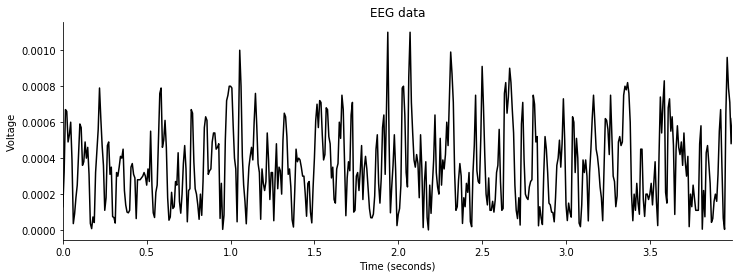

In [422]:
signal = xtrain_eeg1.iloc[10,:].values
# Define sampling frequency and time vector
sf = 128.
time = np.arange(signal.size) / sf

# Plot the signal
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
plt.plot(time, abs(signal), lw=1.5, color='k')
plt.xlabel('Time (seconds)')
plt.ylabel('Voltage')
plt.xlim([time.min(), time.max()])
plt.title('EEG data')
sns.despine()

# Functions for Feature Extraction

In [423]:
###############################################################################
###############################################################################
'''  ## EEG FEATURES ##   '''
###############################################################################
###############################################################################


'''extracting bandpower from eeg signal'''

# Note that yasa's bandpower function limits the row length to the amount of columns divided by 2
# Therefore, iterate in for loop 100 rows at a time

def extract_bandpower_eeg(signal, frequency = 128):
    for i in (np.arange(signal.shape[0] / 100) + 1):
        if i == 1:
            df = yasa.bandpower(signal.iloc[0:int(100*i),:].values, sf=frequency)
        else:
            df = df.append(yasa.bandpower(signal.iloc[int(100*(i-1)):int(100*i),:].values, sf=frequency))
    
    df = df.set_index(np.arange(signal.shape[0]))
    df = df.drop(columns = ["FreqRes","Relative"], axis = 1)
    return df

###############################################################################

'''extracting descriptive statistics for eeg signals'''

def descriptive_statistics_EEG(signal, fs = 128):
    threshold = 0.0005     # to be tuned
    K_boundary = 7         # to be tuned
    t_fisher = 15          # to be tuned
    d_fisher = 30          # to be tuned
    features_num = 4
   
    '''simple statistics'''
    """ TESTED for (nxd) matrix input """
    # Check if it is not a 1d array
    if (len(signal.shape) > 1) and (signal.shape[1]!=1):
        simple_stats = np.array([np.mean(signal, axis=1), 
                        np.median(signal, axis=1),
                        np.std(signal, axis=1), 
                        np.max(signal, axis=1),
                        np.min(signal, axis=1), 
                        kurtosis(signal, axis=1),
                        skew(signal, axis=1), 
                        pd.Series(np.sum(np.abs(signal), axis = 1)), 
                        pd.Series(np.sum(np.abs(signal) > threshold, axis = 1))]).T
    else:
        print("Not Tested with this input!")
        simple_stats =  np.array([np.mean(signal), 
                        np.median(signal), 
                        np.std(sigal),
                        np.max(signal), 
                        np.min(signal), 
                        float(kurtosis(signal)),
                        float(skew(signal))])
        
        
    '''Advanced statistics: Higuchi Fractal Dimension, Fisher Infromation,
    Petrosian Fractal Dimension, Detrended Fluctuation Analysis'''
        
    advanced_stats = np.zeros((signal.shape[0],features_num))
    for i in tqdm((np.arange(signal.shape[0]))):
        feat_array = np.array([pyeeg.dfa(signal.iloc[i,:]), pyeeg.hfd(signal.iloc[i,:], K_boundary), 
                          pyeeg.fisher_info(signal.iloc[i,:], t_fisher, d_fisher), 
                          pyeeg.pfd(signal.iloc[i,:])])
        advanced_stats[i, :] = feat_array 

    union_smpl_adv = np.concatenate((simple_stats, advanced_stats), axis = 1)

    return (union_smpl_adv)

###############################################################################

'''joining bandpower and descriptive statistics'''

def EEG_feature_extraction(signal, fs = 128): 
    eeg_features = np.concatenate((extract_bandpower_eeg(signal, 128), descriptive_statistics_EEG(signal, fs = 128)), axis = 1)
    
    return(eeg_features)



###############################################################################
###############################################################################
'''  ## EMG FEATURES ##   '''
###############################################################################
###############################################################################

'''extracting descriptive statistics for eeg signals'''

def EMG_feature_extraction(signal, fs = 128):
    threshold = 0.0005     # to be tuned
    features_num = 8 
    
    '''simple statistics'''
    """ TESTED for (nxd) matrix input """
    # Check if it is not a 1d array
    if (len(signal.shape) > 1) and (signal.shape[1]!=1):
        simple_stats = np.array([np.mean(signal, axis=1), 
                        np.median(signal, axis=1),
                        np.std(signal, axis=1), 
                        np.max(signal, axis=1),
                        np.min(signal, axis=1), 
                        kurtosis(signal, axis=1),
                        skew(signal, axis=1), 
                        pd.Series(np.sum(np.abs(signal), axis = 1)), 
                        pd.Series(np.sum(np.abs(signal) > threshold, axis = 1))]).T
    else:
        print("Not Tested with this input!")
        simple_stats =  np.array([np.mean(signal), 
                        np.median(signal), 
                        np.std(sigal),
                        np.max(signal), 
                        np.min(signal), 
                        float(kurtosis(signal)),
                        float(skew(signal))])

    '''
    Advanced statistics -- these include: 
    Median values for second, third, fourth and fifth powers of initial emg signal,
    Median of changes in amplitude, 
    Std of changes in amplitude, 
    Lengths of waves, 
    Mean of squared differences of emg signal
    '''
    advanced_stats = np.zeros((signal.shape[0],features_num))
    for i in tqdm((np.arange(signal.shape[0]))):
        feat_array = np.array([np.median(signal.iloc[i,:] ** 2), 
                              np.median(signal.iloc[i,:] ** 3), 
                              np.median(signal.iloc[i,:] ** 4), 
                              np.median(signal.iloc[i,:] ** 5), 
                              np.median(np.abs(np.diff(signal.iloc[i,:]))), 
                              np.std(np.abs(np.diff(signal.iloc[i,:]))), 
                              np.sum(np.abs(np.diff(signal.iloc[i,:]))), 
                              np.mean(np.power(np.diff(signal.iloc[i,:]), 2))])
        advanced_stats[i, :] = feat_array 
        
        union_smpl_adv = np.concatenate((simple_stats, advanced_stats), axis = 1)

    return (union_smpl_adv)


# Feature Extraction

In [424]:
xtrain_eeg_1 = EEG_feature_extraction(xtrain_eeg1, 128)0
xtrain_eeg_2 = EEG_feature_extraction(xtrain_eeg2, 128)
xtrain_emg = EMG_feature_extraction(xtrain_emg, 128)
xtrain = np.concatenate((xtrain_eeg_1, xtrain_eeg_2, xtrain_emg), axis = 1)

print(xtrain_eeg_1.shape, xtrain_eeg_2.shape, xtrain_emg)
print(xtrain.shape)

C:\Users\Nicolò Grometto\AppData\Roaming\Python\Python37\site-packages\pyeeg-0.4.4-py3.7.egg\pyeeg\detrended_fluctuation_analysis.py:125: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  F[i] += numpy.linalg.lstsq(c, y)[1]
C:\Users\Nicolò Grometto\AppData\Roaming\Python\Python37\site-packages\pyeeg-0.4.4-py3.7.egg\pyeeg\detrended_fluctuation_analysis.py:131: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ).T, numpy.log(F))[0][0]
C:\Users\Nicolò Grometto\AppData\Roaming\Python\Python37\site-packages\pyeeg-0.4.4-py3.7.egg\py


(64800, 18) (64800, 18) [[-1.08082031e-05 -1.00000000e-05  1.03004708e-05 ...  9.88406904e-06
   4.16320000e-03  1.64071076e-10]
 [-1.05593750e-05 -9.50000000e-06  9.00428446e-06 ...  8.83439476e-06
   3.68040000e-03  1.29920352e-10]
 [-9.91113281e-06 -9.20000000e-06  8.31664447e-06 ...  7.66333677e-06
   3.34400000e-03  1.01551076e-10]
 ...
 [-9.47851562e-07 -7.75000000e-06  1.15473474e-04 ...  9.60837390e-05
   4.10348000e-02  1.56806463e-08]
 [-3.12695312e-07 -9.30000000e-06  1.10282589e-04 ...  9.36177645e-05
   3.75652000e-02  1.41684634e-08]
 [-3.12695312e-07 -9.30000000e-06  1.10282589e-04 ...  9.36177645e-05
   3.75652000e-02  1.41684634e-08]]
(64800, 53)


In [425]:
pd.DataFrame(xtrain).head()

,0,1,2,3,4,5,6,7,8,9,...,43,44,45,46,47,48,49,50,51,52
0,0.167779,0.589067,0.142509,0.084657,0.015988,-0.000019,-0.000002,0.000449,0.0017,-0.0013,...,0.005885,0.0,1.000000e-10,-1.000000e-15,1.000000e-20,-1.000000e-25,0.000005,0.000010,0.004163,1.640711e-10
1,0.261716,0.384270,0.197637,0.141042,0.015335,-0.000033,-0.000061,0.000540,0.0014,-0.0014,...,0.005581,0.0,9.409000e-11,-8.573750e-16,8.852928e-21,-7.737809e-26,0.000005,0.000009,0.003680,1.299204e-10
2,0.294706,0.191459,0.337027,0.158918,0.017890,-0.000043,-0.000041,0.000563,0.0018,-0.0014,...,0.005412,0.0,9.025000e-11,-7.786880e-16,8.145063e-21,-6.590815e-26,0.000004,0.000008,0.003344,1.015511e-10
3,0.168293,0.581209,0.130216,0.105173,0.015109,-0.000046,-0.000059,0.000502,0.0019,-0.0013,...,0.005845,0.0,1.000000e-10,-1.000000e-15,1.000000e-20,-1.000000e-25,0.000004,0.000008,0.003436,1.129337e-10
4,0.239408,0.542883,0.131650,0.076140,0.009920,-0.000004,-0.000024,0.000590,0.0017,-0.0017,...,0.005167,0.0,7.225000e-11,-6.141250e-16,5.220062e-21,-4.437053e-26,0.000004,0.000008,0.003246,1.044935e-10


# Model Selection -- Grid Search CV

In [426]:
steps = [("scaler", StandardScaler()), ("classifier", SVC())]
pipeline = Pipeline(steps = steps)

parameters = {"classifier__kernel": ["rbf"],
              "classifier__gamma": ["auto"],
              "classifier__C": [0.3, 0.5, 0.7, 1, 5, 10],  
              "classifier__class_weight": ["balanced"]
             }

grid = GridSearchCV(pipeline, parameters, cv = 3, scoring = 'balanced_accuracy', verbose = 2)

grid.fit(xtrain, ytrain.values.ravel())
print(grid.best_score_)
print(grid.best_params_)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] classifier__C=0.3, classifier__class_weight=balanced, classifier__gamma=auto, classifier__kernel=rbf 
[CV]  classifier__C=0.3, classifier__class_weight=balanced, classifier__gamma=auto, classifier__kernel=rbf, total=  21.1s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   21.0s remaining:    0.0s


[CV] classifier__C=0.3, classifier__class_weight=balanced, classifier__gamma=auto, classifier__kernel=rbf 
[CV]  classifier__C=0.3, classifier__class_weight=balanced, classifier__gamma=auto, classifier__kernel=rbf, total=  30.8s
[CV] classifier__C=0.3, classifier__class_weight=balanced, classifier__gamma=auto, classifier__kernel=rbf 
[CV]  classifier__C=0.3, classifier__class_weight=balanced, classifier__gamma=auto, classifier__kernel=rbf, total=  29.1s
[CV] classifier__C=0.5, classifier__class_weight=balanced, classifier__gamma=auto, classifier__kernel=rbf 
[CV]  classifier__C=0.5, classifier__class_weight=balanced, classifier__gamma=auto, classifier__kernel=rbf, total=  18.1s
[CV] classifier__C=0.5, classifier__class_weight=balanced, classifier__gamma=auto, classifier__kernel=rbf 
[CV]  classifier__C=0.5, classifier__class_weight=balanced, classifier__gamma=auto, classifier__kernel=rbf, total=  28.5s
[CV] classifier__C=0.5, classifier__class_weight=balanced, classifier__gamma=auto, c

[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:  7.7min finished


0.9137133317018651
{'classifier__C': 0.3, 'classifier__class_weight': 'balanced', 'classifier__gamma': 'auto', 'classifier__kernel': 'rbf'}
